In [1]:
from google.cloud import storage
import pandas as pd
import numpy as np
from scipy.io import mmread
import pyreadr
import anndata
import matplotlib.pyplot as plt
from collections import defaultdict, Counter, OrderedDict

import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import scanpy as sc
import seaborn as sns
from sklearn.decomposition import PCA
import umap
import matplotlib.patches as mpatches
import phenograph
from sklearn.neighbors import kneighbors_graph
import random
from scipy.stats import zscore, ttest_ind

### function for taking a dataframe and log-normalizing
def log_normalize(counts):
    ms = counts.sum(axis=1)
    norm_df = counts.div(ms, axis=0).mul(np.median(ms),axis=0)
    data_df = np.log(norm_df + 0.1)
    data_df = data_df.astype(np.float32)
    return data_df

### function for generating random colors for plotting
def random_colors(n): #n is the number of colors you need to generate
    color_set = np.zeros((n,3))
    for i in range(n):
        r = random.uniform(0, 1)
        b = random.uniform(0, 1)
        g = random.uniform(0, 1)
        color_set[i] = [r,b,g]
    return color_set


### takes a dictionary of gene signatures and plots average expression on umap
def plot_expression(dictionary, umap_, subset = None, zscore_ = False, fig_size = [11,8]):   
    n = len(dictionary); max_cols = 3
    nrows = int(np.ceil(n / max_cols)); ncols = int(min((max_cols, n)))
    fig = plt.figure(figsize=[fig_size[0]* ncols, fig_size[1]*nrows])
    i = 0
    cmap = plt.cm.Spectral_r
        
    for sample in dictionary:
#         print(sample)
        ax = fig.add_subplot(nrows, ncols, i+1)
        c=dictionary[sample]
        umap_["c"] = c
        if subset is None:
            umap_subset = umap_
        else:
            plt.scatter(umap_['x'],umap_['y'],s=1, edgecolors='none', color ="lightgrey")
            umap_subset = umap_.loc[subset.index]
            
        umap_shuffle = umap_subset.sample(frac = 1)
        
        if zscore_ == True:
            plot = ax.scatter(umap_shuffle['x'],umap_shuffle['y'],s=5,vmin =-1, vmax = 1, edgecolors='none', cmap = cmap,  c=zscore(umap_shuffle['c']))
        else: 
            plot = ax.scatter(umap_shuffle['x'],umap_shuffle['y'],s=5, edgecolors='none', cmap = cmap,  c=umap_shuffle['c'])
        fig.colorbar(plot,ax=ax)
        ax.set_title(sample, fontsize = 24)
        ax.set_axis_off()
        i += 1
    fig.tight_layout()
    plt.savefig('CLLvsT_expD.eps',format = 'eps')
    plt.show()
    return

### just plots some clusters based on array, i.e. group = [0,3,4,5] would only plot clusters 0,3,4,5
def plot_someclusters(group, umap_, string = ""):
    color_set = random_colors(n_cluster_knn+2)
    plt.figure(figsize = (6,6))
    plt.scatter(umap_['x'], umap_['y'],
                s=1, edgecolors='none',color='lightgrey')
    for i,cluster in enumerate(group): 
            bool_array = umap_.cluster_number == cluster
            cells = umap_.index[bool_array]
            plt.scatter(umap_.loc[cells, 'x'], umap_.loc[cells, 'y'],
                    s=1, edgecolors='none', label = cluster,color=color_set[i])
    plt.legend(bbox_to_anchor=(1.01,0.5), loc='center left', markerscale = 6)
    plt.title(string)
    plt.show()
    return



In [34]:
counts = pd.read_pickle('car_t_counts.pkl')

In [35]:
adata = sc.AnnData(counts)

In [37]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

In [38]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [41]:
samp = [cell.split('_')[0] for cell in adata.obs.index]
adata.obs['sample'] = samp

In [ ]:
# !pip install 

In [47]:
sc.external.pp.scrublet(adata)

/home/cyp2111_columbia_edu/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.64
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 11.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


In [48]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [49]:
sc.pp.log1p(adata)

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [50]:
adata.raw = adata

In [ ]:
adata = adata[:, adata.var.highly_variable]

In [51]:
sc.tl.pca(adata, svd_solver="arpack")

/home/cyp2111_columbia_edu/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample' as categorical


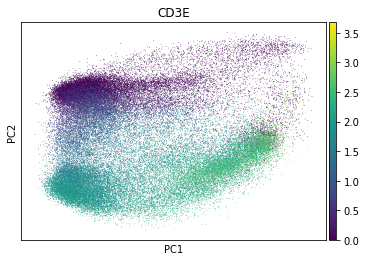

In [52]:
sc.pl.pca(adata, color="CD3E")

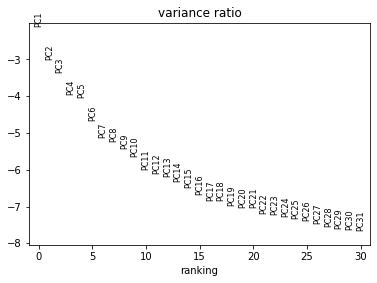

In [53]:
sc.pl.pca_variance_ratio(adata, log=True)

In [54]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)

In [55]:
sc.tl.umap(adata)

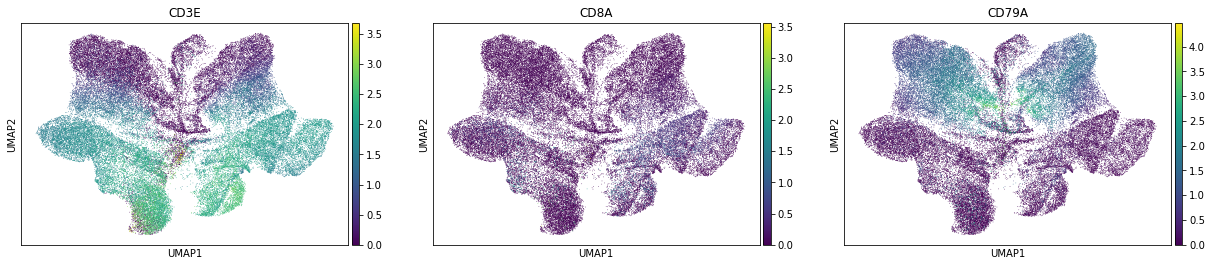

In [56]:
sc.pl.umap(adata, color=["CD3E", "CD8A", "CD79A"])

In [77]:
sc.tl.leiden(
    adata,
    resolution=0.5,
    random_state=0,
    n_iterations=2,
    directed=False,
)

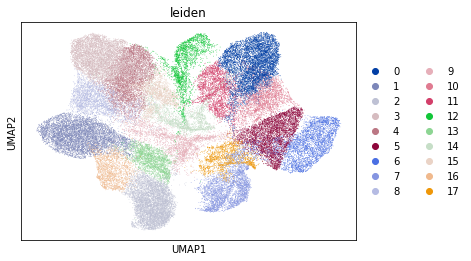

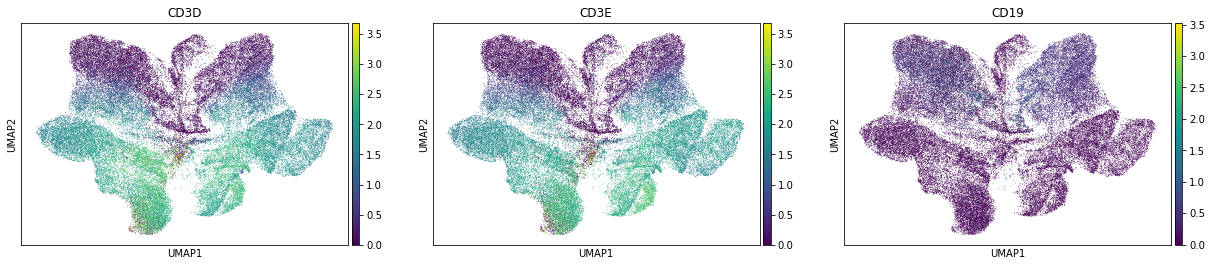

In [98]:
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["CD3D",'CD3E','CD19'])

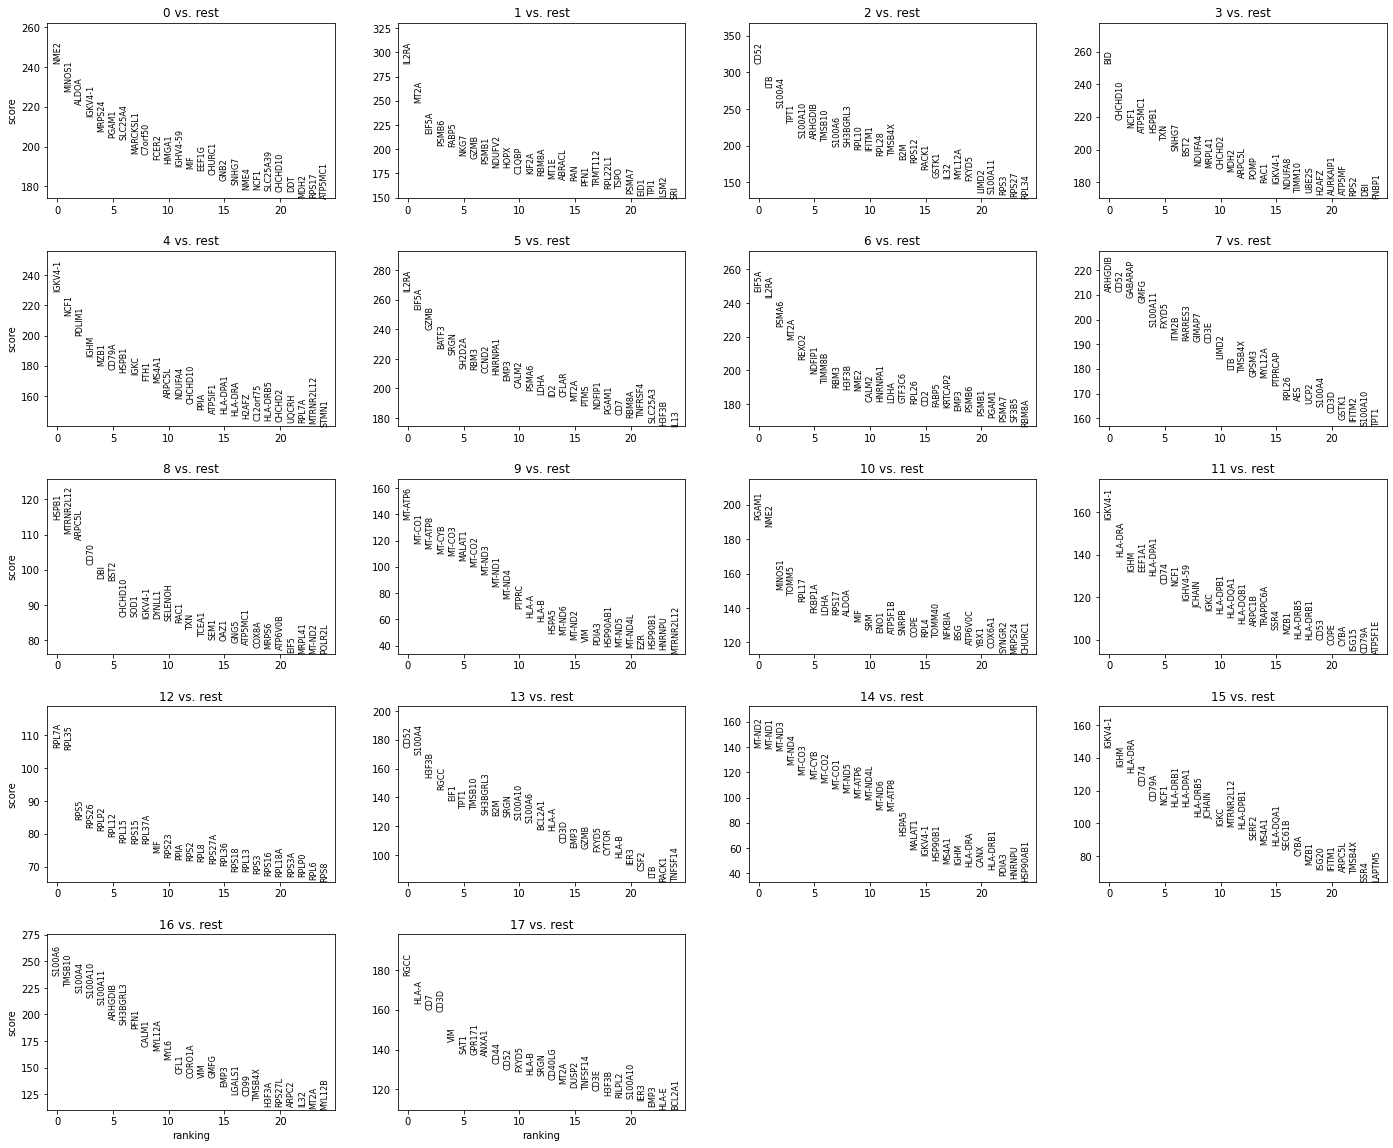

In [79]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

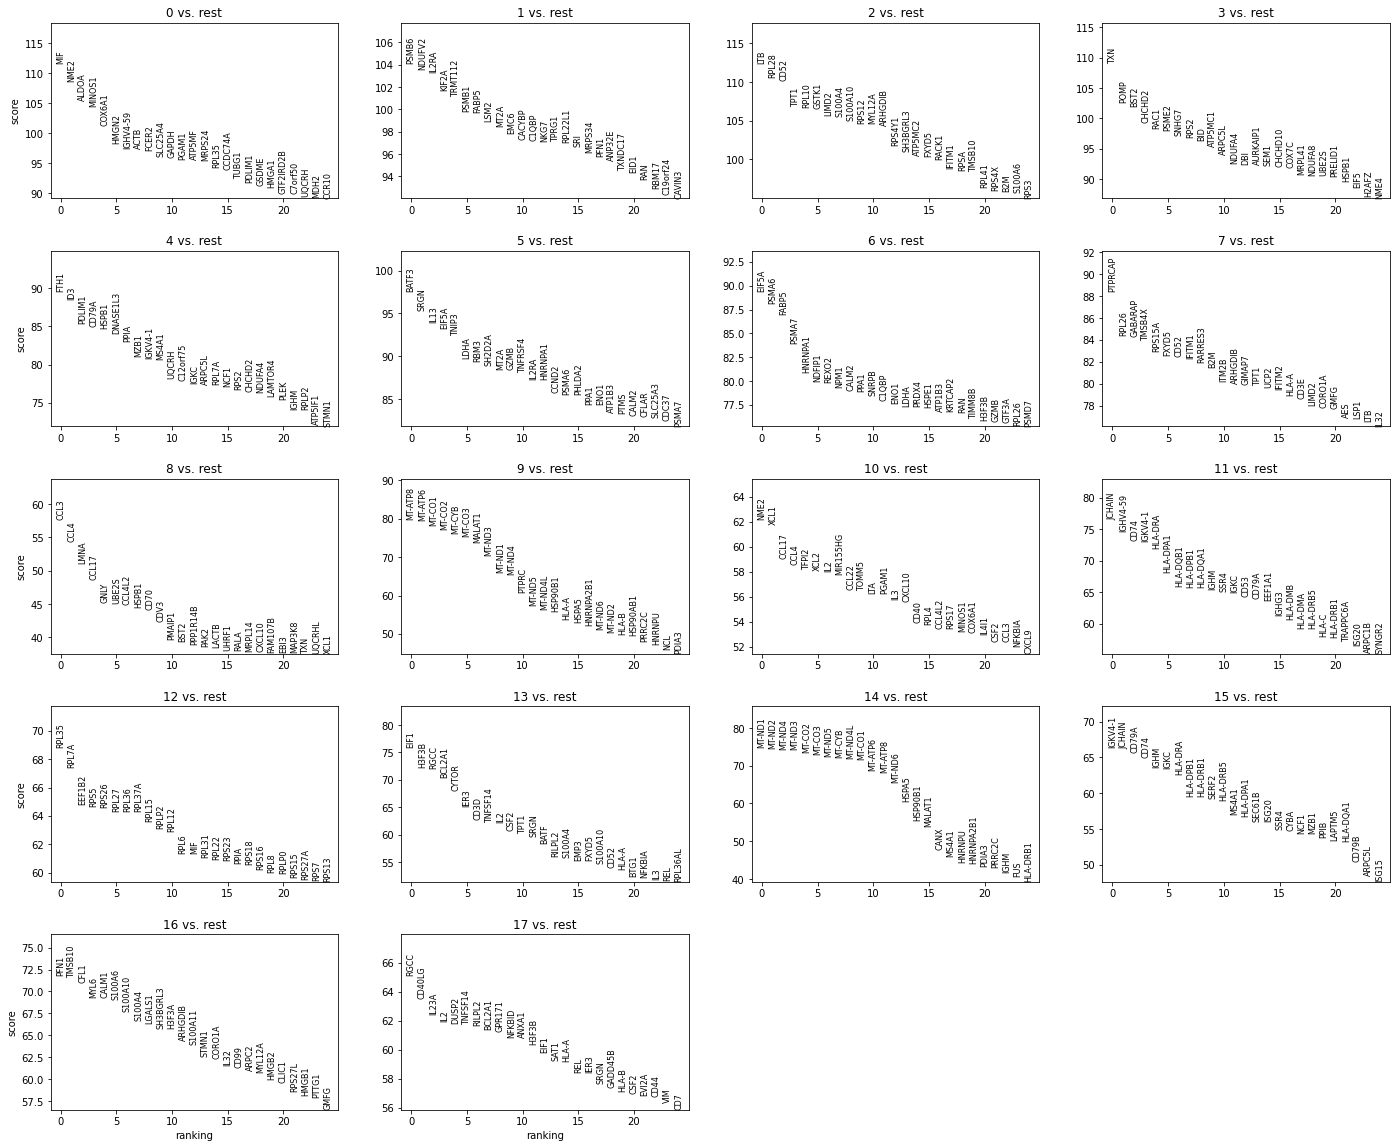

In [80]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

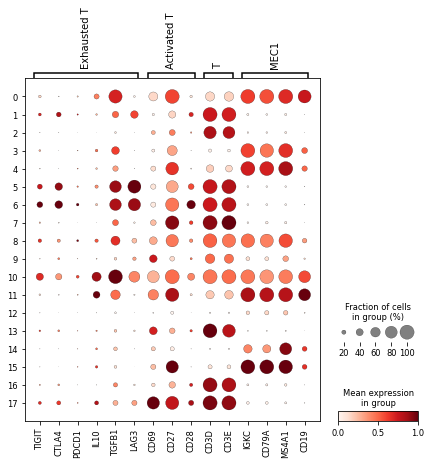

In [81]:
marker_genes = {
    "Exhausted T": ['TIGIT','CTLA4','PDCD1','IL10','TGFB1','LAG3'],
    "Activated T": ['CD69','CD27','CD28'],
    "T": ['CD3D','CD3E'],
    "MEC1": ["IGKC", "CD79A", "MS4A1", "CD19"],
}


sc.pl.dotplot(adata, marker_genes, groupby="leiden", standard_scale="var")



In [82]:
adata

AnnData object with n_obs × n_vars = 61437 × 20118
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'sample', 'doublet_score', 'predicted_doublet', 'leiden'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [91]:
umap_ = pd.DataFrame({'x':adata.obsm['X_umap'][:,0],'y':adata.obsm['X_umap'][:,1]}, index = adata.obs.index)
umap_['cluster_number'] = adata.obs['leiden']

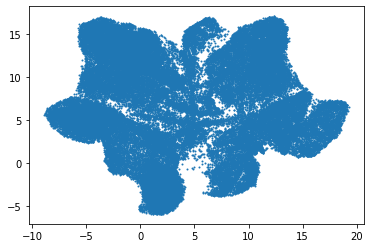

In [94]:
plt.scatter(umap_['x'],umap_['y'], s = 1)

In [103]:
doublets = [8,10]
MEC1 = [0,3,4,11,14,15]
exhausted = [5,6]
activated = [7,9,17]
other = [1,2,13,16]

umap_['metacluster'] = 'X'
umap_['cluster_number'] = umap_['cluster_number'].astype(int)
cells = umap_.index[umap_['cluster_number'].isin(MEC1)]
umap_.loc[cells,'metacluster'] = 'MEC1'

cells = umap_.index[umap_['cluster_number'].isin(exhausted)]
umap_.loc[cells,'metacluster'] = 'exhausted'

cells = umap_.index[umap_['cluster_number'].isin(activated)]
umap_.loc[cells,'metacluster'] = 'activated'

cells = umap_.index[umap_['cluster_number'].isin(other)]
umap_.loc[cells,'metacluster'] = 'other'

cells = umap_.index[umap_['cluster_number'].isin(doublets)]
umap_.loc[cells,'metacluster'] = 'doublets'

In [105]:
umap_.to_csv('car_t_leiden.csv')